# ORTHOGONAL POLYNOMIAL DENSITY ESTIMATION
## Preliminaries
### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import numpy.polynomial.legendre as npl

from scipy.optimize import minimize

### Notebook settings

In [2]:
%matplotlib notebook
sbn.set_style('white')

legend_params = {'loc': 'best',
                 'frameon': True, 
                 'fancybox': True, 
                 'framealpha': 0.7}

## Create Synthetic Data
Data are projected into the [-0.9, 0-9] interval.

<IPython.core.display.Javascript object>


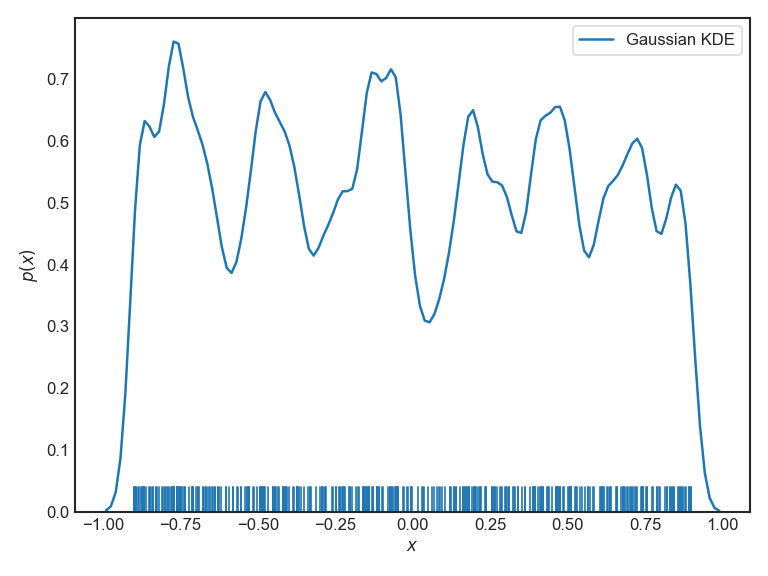

In [3]:
N = 400

x = np.random.uniform(low=-10.0, high=10.0, size=N)
#x1 = np.random.laplace(loc=-5, size=N)
#x2 = np.random.laplace(loc=7, size=int(N/2))
#x3 = np.random.laplace(loc=-15, size=int(N/3))
#x = np.append(np.append(x1, x2), x3)

x -= 0.5*(x.min() + x.max())
x /= (x.max() - x.min())
x *= 1.8
x.sort()

#x = np.zeros(N)

fig, ax = plt.subplots()
sbn.distplot(x, hist=False, rug=True, kde_kws={'bw': 0.03}, label='Gaussian KDE', ax=ax)
ax.set(xlabel=r'$x$', ylabel=r'$p(x)$')
ax.legend(**legend_params)
fig.tight_layout()

## Maximum Likelihood Estimate of the Density
### Initialize Legendre polynomials
Choose polynomial degree $J$, initialize coefficients $\mathbf{c}$, and compute basis-function values at all values of $x$.

In [4]:
J = 29

c = np.zeros(J+1)
c[0] = 1
c = np.append(c, 400)

norm = np.array([np.sqrt(2/(2*j + 1)) for j in range(J+1)])
phi_jn = npl.legvander(x, J).T / norm[:, np.newaxis]

### Likelihood and constraint

In [11]:
def neglogl(c):
    return -np.log(np.square(c.dot(phi_jn))).sum()

def grad_neglogl(c):
    return -2*(phi_jn / c.dot(phi_jn)).sum(axis=1)

def normalization(c):
    return c.dot(c) - 1

def grad_normalization(c):
    return 2*c

constraint = {'type': 'eq',
              'fun': normalization,
              'jac': grad_normalization}

option = {'maxiter': 5000}

### Compound objective function

In [12]:
def objective(c):
    return -np.log(np.square(c[:-1].dot(phi_jn))).sum() + c[-1]*(c[:-1].dot(c[:-1]) - 1)

def grad_objective(c):
    return np.append(-2*(phi_jn / c[:-1].dot(phi_jn)).sum(axis=1) + 2*c[-1]*c[:-1], c[:-1].dot(c[:-1]) - 1)

def hess_objective(c):
    return 2*np.eye(J+1)

### Direct optimization of compound objective function

In [16]:
res_direct = minimize(objective, c, method='newton-cg', jac=grad_objective, options=option)
res_direct.x[:-1].dot(res_direct.x[:-1])

1.000003157148553

### Contrained minimization of negative log-likelihood

In [17]:
res_constrained = minimize(neglogl, c[:-1], method='slsqp', jac=grad_neglogl, constraints=constraint, options=option)
res_constrained.x.dot(res_constrained.x)

1.0000000000013978

### Plot comparative results
The estimated density is evaluated on a uniform grid.

<IPython.core.display.Javascript object>


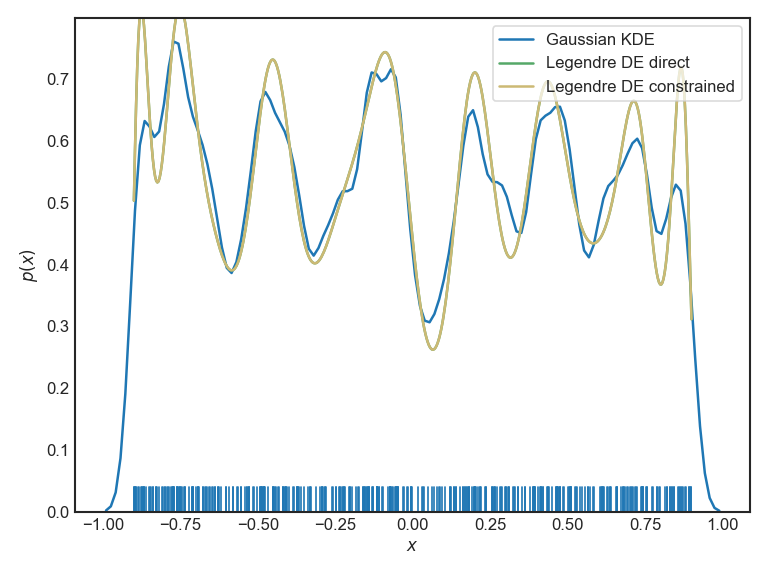

In [19]:
x_grid = np.linspace(-0.9, 0.9, 500)
phi_jn_grid = npl.legvander(x_grid, J).T / norm[:, np.newaxis]

fig, ax = plt.subplots()
sbn.distplot(x, hist=False, rug=True, kde_kws={'bw': 0.03}, label='Gaussian KDE', ax=ax)
ax.plot(x_grid, np.square(res_direct.x[:-1].dot(phi_jn_grid)), color='#55a868', label='Legendre DE direct')
ax.plot(x_grid, np.square(res_constrained.x.dot(phi_jn_grid)), color='#ccb974', label='Legendre DE constrained')
ax.set(xlabel=r'$x$', ylabel=r'$p(x)$')
ax.legend(**legend_params)
fig.tight_layout()

## Density Gradient

<IPython.core.display.Javascript object>


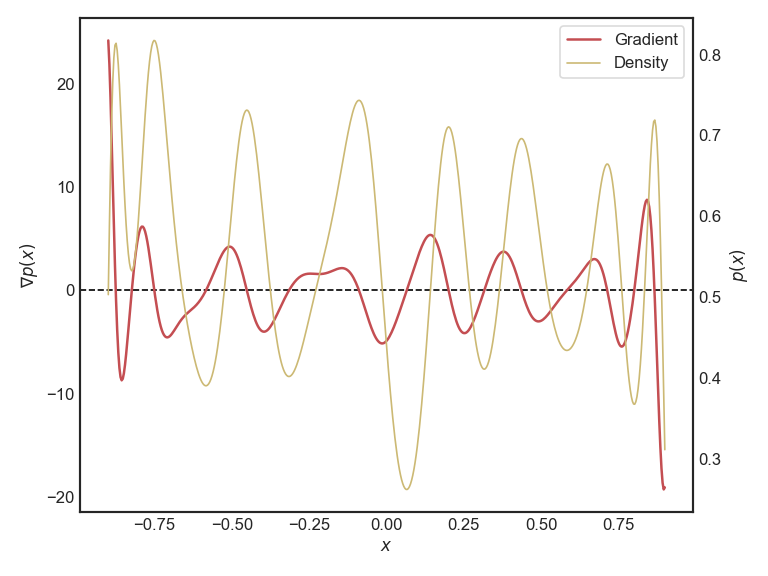

In [21]:
coeffs_of_gradient = npl.legder(res_direct.x[:-1]/norm)
gradient = 2*npl.legval(x_grid, res_direct.x[:-1]/norm)*npl.legval(x_grid, coeffs_of_gradient)

fig, grad_ax = plt.subplots()
grad_ax.axhline(color ='k', linewidth=1.0, linestyle='--')
grad_ax.plot(x_grid, gradient, color='#c44e52', label='Gradient')
grad_ax.set(xlabel=r'$x$', ylabel=r'$\nabla p(x)$')
dens_ax = grad_ax.twinx()
dens_ax.plot(x_grid, np.square(res_direct.x[:-1].dot(phi_jn_grid)), color='#ccb974', linewidth=1.0, label='Density')
dens_ax.set_ylabel(r'$p(x)$')

grad_line, grad_label = grad_ax.get_legend_handles_labels()
dens_line, dens_label = dens_ax.get_legend_handles_labels()
dens_ax.legend(grad_line+dens_line, grad_label+dens_label, **legend_params)

fig.tight_layout()